# Tool Calling and Execution with LangChain

**Purpose:**  
Demonstrate how models can be augmented with external tools, how tools are defined and bound, and how tool execution loops enable models to request and consume external function results.

## Core concepts

**Tools**  
A tool is a callable interface exposed to a model. It consists of:
1) A schema (name, description, and argument specification), and  
2) An executable function or coroutine.

The schema allows the model to reason about when and how to call the tool. The function implements the actual side effect or computation.

**Tool binding**  
Binding tools attaches tool schemas to a model so it can emit structured tool calls instead of plain text when appropriate.

**Tool execution loop**  
The execution loop is the control flow that:
1) Lets the model propose tool calls,  
2) Executes the corresponding functions, and  
3) Feeds the results back to the model so it can continue reasoning or produce a final answer.


In [ ]:
# Environment and base model setup

import os
from langchain.chat_models import init_chat_model

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

model = init_chat_model("groq:qwen/qwen3-32b")
response = model.invoke("Why do parrots talk?")
response

AIMessage(content='<think>\nOkay, so the user is asking why parrots talk. Let me start by recalling what I know about parrots. Parrots are known for their ability to mimic human speech, but why do they do that? Maybe they\'re trying to communicate with humans? But how does that fit into their natural behavior?\n\nFirst, I should think about their natural behavior in the wild. Parrots are social animals. They live in groups, right? So in the wild, they might use vocalizations to interact with each other, to establish dominance, attract mates, or warn others about danger. That makes sense. So if they\'re social, vocal communication is essential for their survival and social structure.\n\nNow, when they\'re kept as pets, they might try to communicate with their human companions. But why do they mimic humans specifically? Maybe because they learn that making sounds gets a response. Positive reinforcement? Like, if a parrot says a word and gets attention, food, or affection, they might repe

## Method 1 — Agent-based tool orchestration

This pattern uses a higher-level agent abstraction that manages planning, tool selection, execution, and iteration internally.

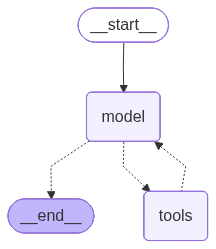

In [11]:
# Method 1


from langchain.agents import create_agent
from langchain_groq import ChatGroq

llm = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model= "openai/gpt-oss-20b",
    temperature=0
)
def get_weather(city:str)-> str:
    """Get the weather for a city."""
    return f"The weather in {city} is sunny."

agent=create_agent(
    model="gpt-5",
    tools=[get_weather],
    system_prompt="You are a helpful assistant."
)
agent


## Method 2 — Direct tool binding

This pattern binds tools directly to a model. The model decides when to call them and returns structured tool call objects that the application must execute.


In [ ]:
# Define a tool using a decorator to expose schema + function

from langchain.tools import tool

@tool
def get_weather(location:str)->str:
    """Get the weather at a location"""
    return f"It's sunny in {location}"


# Bind the tool to the model
model_with_tools=model.bind_tools([get_weather])

### Note: Role of docstrings in tool definitions

Docstrings serve as the natural-language interface contract between the tool and the model.

When a function is exposed as a tool, its docstring is used to:
- Describe the tool’s purpose and intended usage to the model.
- Help the model decide *when* the tool is relevant.
- Guide the model in forming correct arguments for the tool call.

In practice, a clear and specific docstring significantly improves tool selection accuracy and reduces malformed or unnecessary tool invocations.


In [ ]:
response = model_with_tools.invoke("What's the weather like in Boston?")
print(response)

# Inspect tool calls emitted by the model

for tool_call in response.tool_calls:
    # View tool calls made by the model
    print(f"Tool: {tool_call['name']}")
    print(f"Args: {tool_call['args']}")

content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking about the weather in Boston. I need to use the get_weather function. Let me check the function parameters. It requires a location, which in this case is Boston. I\'ll call the function with "Boston" as the location argument. Make sure the JSON is correctly formatted with the name and arguments. No other functions are needed here. Just a straightforward call to get_weather with Boston.\n', 'tool_calls': [{'id': 'qn1qeehvj', 'function': {'arguments': '{"location":"Boston"}', 'name': 'get_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 154, 'total_tokens': 262, 'completion_time': 0.193465488, 'completion_tokens_details': {'reasoning_tokens': 84}, 'prompt_time': 0.007995882, 'prompt_tokens_details': None, 'queue_time': 0.074992921, 'total_time': 0.20146137}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_d58dbe76cd', 'service_tier': 'on_dema

## Tool execution loop

The application is responsible for executing tools and returning their outputs to the model. This allows deterministic control over side effects and integration with external systems.


In [10]:
# Step 1: Model generates tool calls
messages = [{"role": "user", "content": "What's the weather in Boston?"}]
ai_msg = model_with_tools.invoke(messages)
messages.append(ai_msg)

# Step 2: Execute tools and collect results
for tool_call in ai_msg.tool_calls:
    # Execute the tool with the generated arguments
    tool_result = get_weather.invoke(tool_call)
    messages.append(tool_result)

# Step 3: Pass results back to model for final response
final_response = model_with_tools.invoke(messages)
print(final_response.text)
# "The current weather in Boston is 72°F and sunny."

The weather in Boston is sunny.


## Summary

- Tools extend model capabilities with deterministic, external functions.
- Binding tools exposes structured call interfaces to the model.
- The execution loop enables safe, explicit orchestration of model-driven side effects.
- Agents automate this loop, while direct binding provides finer-grained control.
